# Spatial Statistics and Machine Learning -  Case Study: The Reprise of the Far Right
## Investigating Spatial Heterogeneity in Far-Right Voting Behaviour in the 2025 German Federal Elections

### Authors:
- Marion Späth		2772981
- Katia Tseliou		2500434
- Morgan Arima		9374752
- Joris Burger		0859427


### Research Questions: 
1. What factors influenced far-right voting behavior for the AfD in the 2025 German general elections?
2. To what extent does the explanatory power of different factors vary across space?

# PART 2:

This code was used for some further data exploration, for the VIF analysis and variable standardisation. A shortend version of the original dataset is written which contains only the (standardised) variables needed for the GWR and (S)RF models. Subsequently, the GWR is estimated in this notebook.

In [ ]:
#!pip install mgwr

In [ ]:
#!pip install esda

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mgwr.gwr import GWR
# from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
# from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as mticker
from libpysal import weights
from esda.moran import Moran
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [ ]:
# Load the data
gdf = gpd.read_file("sample_data/df_full_post_data_collection.gpkg")

In [ ]:
gdf.iloc[:, :-1]

,target_id,WKR_NR,WKR_NAME,LAND_NR,LAND_NAME,Gebietsname,Gruppenname,Prozent,VorpProzent,east,...,disposable_income_interpolated,proportion_residential_transport_interpolated,unemployment_rate_interpolated,crime_count_per100.000_interpolated,area_sqm,population_density_km2,prop_18-29,prop_above64,attack,distance_terror
0,0,1,Flensburg – Schleswig,01,Schleswig-Holstein,Flensburg – Schleswig,AfD,"15,256022","5,775787",0,...,24190.379301,12.221872,5.265214,4.926610,2.126117e+09,139.814066,0.136473,0.232806,0,302.444497
1,1,2,Nordfriesland – Dithmarschen Nord,01,Schleswig-Holstein,Nordfriesland – Dithmarschen Nord,AfD,"16,065402","6,103576",0,...,26821.300984,11.074968,5.050627,5.525359,2.784864e+09,84.478451,0.122681,0.250883,0,311.521008
2,2,3,Steinburg – Dithmarschen Süd,01,Schleswig-Holstein,Steinburg – Dithmarschen Süd,AfD,"20,360017","8,365838",0,...,24485.201512,11.695009,5.650089,5.618501,2.013179e+09,109.898809,0.115681,0.236203,0,244.283160
3,3,4,Rendsburg-Eckernförde,01,Schleswig-Holstein,Rendsburg-Eckernförde,AfD,"16,020181","6,563325",0,...,25748.946539,11.500370,4.400063,4.434131,2.163325e+09,118.241623,0.109728,0.237843,0,260.797538
4,4,5,Kiel,01,Schleswig-Holstein,Kiel,AfD,"10,753199","4,935899",0,...,22086.452820,50.641019,7.048012,9.606722,1.430678e+08,1868.603158,0.192686,0.199456,0,255.114010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,294,295,Zollernalb – Sigmaringen,08,Baden-Württemberg,Zollernalb – Sigmaringen,AfD,"26,222105","12,067526",0,...,25247.428848,11.707732,3.712815,4.752305,1.654946e+09,152.249111,0.131932,0.221301,0,167.560496
295,295,296,Saarbrücken,10,Saarland,Saarbrücken,AfD,"20,063599","9,258653",0,...,21856.049600,32.299613,9.499814,9.761865,3.260707e+08,821.162388,0.146991,0.231299,0,167.572179
296,296,297,Saarlouis,10,Saarland,Saarlouis,AfD,"21,713277","10,014781",0,...,21359.878395,18.227548,4.889377,5.829217,8.932205e+08,309.689477,0.118715,0.242653,0,175.793502
297,297,298,St. Wendel,10,Saarland,St. Wendel,AfD,"20,735588","9,416779",0,...,23122.354785,20.660811,5.228633,5.396525,8.023641e+08,271.083900,0.110106,0.257696,0,149.942782


In [ ]:
gdf.columns

Index(['target_id', 'WKR_NR', 'WKR_NAME', 'LAND_NR', 'LAND_NAME',
       'Gebietsname', 'Gruppenname', 'Prozent', 'VorpProzent', 'east',
       'percentAfD25', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'prop_houseowners_mean', 'avg_rent_SQM_mean', 'avg_livingspace_mean',
       'population_count_sum', 'below18_sum', 'a18-29_sum', 'a30-49_sum',
       'a50-64_sum', 'above64_sum', 'proportion_agriculture_interpolated',
       'disposable_income_interpolated',
       'proportion_residential_transport_interpolated',
       'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
       'area_sqm', 'population_density_km2', 'prop_18-29', 'prop_above64',
       'attack', 'distance_terror', 'geometry'],
      dtype='object')

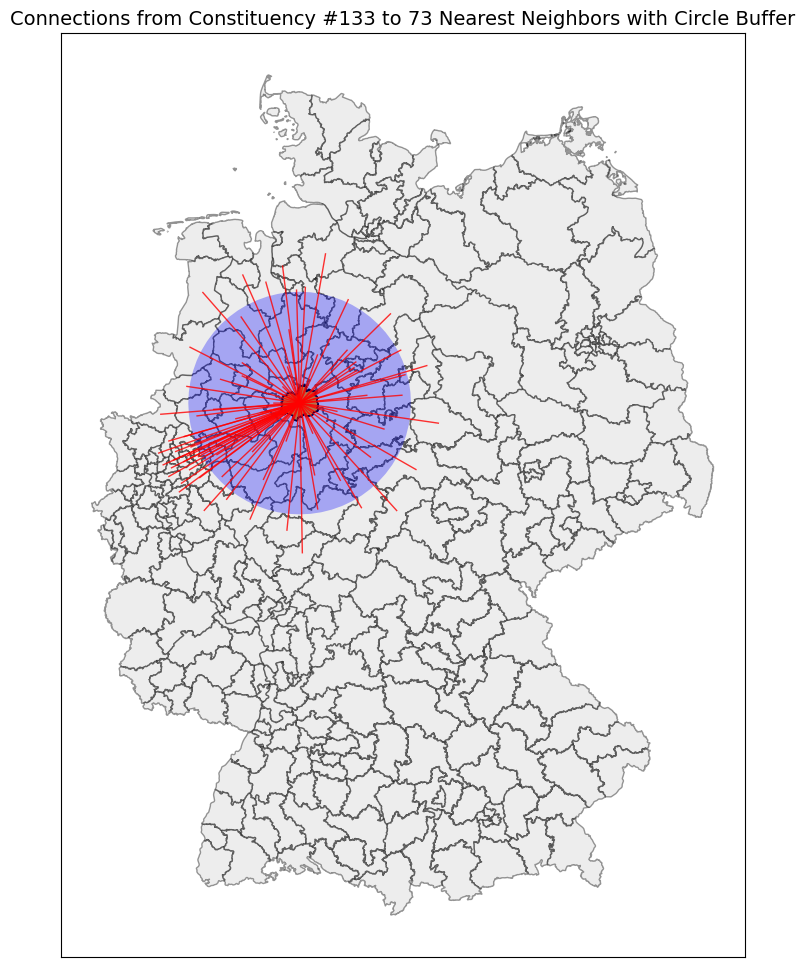

In [ ]:
from libpysal.weights import KNN
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt

# Choose the constituency index you want to visualize
# index = 48  # big kernel
index = 133 # small kernel # 101 | 50 | 250

# Define KNN weights (if not already defined)
k = 73  # Number of neighbors
knn = KNN.from_dataframe(gdf, k=k)

# Get the origin point
origin = gdf.geometry.iloc[index].centroid  # Access geometry directly

# Create a buffer (circle) of 114704 meters around the origin
origin_buffer = origin.buffer(114704)  # Buffer of 114,704 meters

# Get the neighbors of that constituency
neighbors = knn.neighbors[index]

# Create lines only from the selected constituency to its neighbors
lines = []
for neighbor_idx in neighbors:
    destination = gdf.geometry.iloc[neighbor_idx].centroid  # Access geometry directly
    lines.append(LineString([origin, destination]))

# Convert to GeoDataFrame
lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=gdf.crs)

# Create a GeoDataFrame for the buffer
buffer_gdf = gpd.GeoDataFrame(geometry=[origin_buffer], crs=gdf.crs)

# Plotting
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all constituencies
gdf.plot(ax=ax, edgecolor="black", alpha=0.4, color="lightgray")

# Highlight the selected constituency
gdf.iloc[[index]].plot(ax=ax, color="orange", edgecolor="black")

# Plot the connection lines
lines_gdf.plot(ax=ax, color="red", linewidth=1, alpha=0.8)

# Plot the buffer circle
buffer_gdf.plot(ax=ax, color="blue", alpha=0.3)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Add title
ax.set_title(f"Connections from Constituency #{index} to 73 Nearest Neighbors with Circle Buffer", fontsize=14)

plt.show()

In [ ]:
# Get rid of useless columns
# data = gdf.drop(columns=['target_id', 'WKR_NR', 'WKR_NAME', 'LAND_NR', 'LAND_NAME',
#                         'Gebietsname', 'Gruppenname', 'Prozent', 'VorpProzent'])

data = gdf.drop(columns=['target_id', 'WKR_NR', 'WKR_NAME', 'LAND_NR', 'LAND_NAME',
                        'Gebietsname', 'Gruppenname', 'Prozent', 'VorpProzent',
                        'below18_sum', 'a18-29_sum', 'a30-49_sum',
                        'a50-64_sum', 'above64_sum', 'attack', 'population_density_km2']) # We get rid of certain age variables, because we only want ones that could be useful

In [ ]:
data.iloc[:, :-1]

,east,percentAfD25,percentAfD21,prop_foreigners_mean,avg_age_mean,prop_houseowners_mean,avg_rent_SQM_mean,avg_livingspace_mean,population_count_sum,proportion_agriculture_interpolated,disposable_income_interpolated,proportion_residential_transport_interpolated,unemployment_rate_interpolated,crime_count_per100.000_interpolated,area_sqm,prop_18-29,prop_above64,distance_terror
0,0,15.256022,5.775787,8.723799,45.903013,70.505321,5.975574,69.401408,297261.0,72.551096,24190.379301,12.221872,5.265214,4.926610,2.126117e+09,0.136473,0.232806,302.444497
1,0,16.065402,6.103576,12.363946,46.603843,74.549274,6.393666,70.489482,235261.0,75.574984,26821.300984,11.074968,5.050627,5.525359,2.784864e+09,0.122681,0.250883,311.521008
2,0,20.360017,8.365838,9.106659,46.525473,75.411127,5.651154,70.514238,221246.0,72.011747,24485.201512,11.695009,5.650089,5.618501,2.013179e+09,0.115681,0.236203,244.283160
3,0,16.020181,6.563325,10.005899,46.217377,69.351069,6.185440,68.687751,255795.0,69.399772,25748.946539,11.500370,4.400063,4.434131,2.163325e+09,0.109728,0.237843,260.797538
4,0,10.753199,4.935899,9.773604,44.441231,45.844839,7.566480,54.100000,267337.0,31.334524,22086.452820,50.641019,7.048012,9.606722,1.430678e+08,0.192686,0.199456,255.114010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0,26.222105,12.067526,11.703787,44.656663,76.332993,5.792193,65.863015,251964.0,46.966620,25247.428848,11.707732,3.712815,4.752305,1.654946e+09,0.131932,0.221301,167.560496
295,0,20.063599,9.258653,14.628483,46.363307,59.617241,5.813318,64.491728,267757.0,24.400974,21856.049600,32.299613,9.499814,9.761865,3.260707e+08,0.146991,0.231299,167.572179
296,0,21.713277,10.014781,13.444911,46.702109,75.126426,5.773312,70.076457,276621.0,43.364416,21359.878395,18.227548,4.889377,5.829217,8.932205e+08,0.118715,0.242653,175.793502
297,0,20.735588,9.416779,7.999195,47.259983,76.974255,5.182563,70.509796,217508.0,42.394441,23122.354785,20.660811,5.228633,5.396525,8.023641e+08,0.110106,0.257696,149.942782


In [ ]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ['Column Name', 'Data Type']
print(dtype_df)

                                      Column Name Data Type
0                                            east     int32
1                                    percentAfD25   float64
2                                    percentAfD21   float64
3                            prop_foreigners_mean   float64
4                                    avg_age_mean   float64
5                           prop_houseowners_mean   float64
6                               avg_rent_SQM_mean   float64
7                            avg_livingspace_mean   float64
8                            population_count_sum   float64
9             proportion_agriculture_interpolated   float64
10                 disposable_income_interpolated   float64
11  proportion_residential_transport_interpolated   float64
12                 unemployment_rate_interpolated   float64
13            crime_count_per100.000_interpolated   float64
14                                       area_sqm   float64
15                                     p

# Scaling the data

In [ ]:
data_scaled = data.copy()

# Select numerical columns (excluding binary variables if needed)
num_cols = data.drop(columns=['percentAfD25']).select_dtypes(include=['float64']).columns
binary_cols = [col for col in num_cols if data[col].nunique() == 2]  # Identify binary columns
num_cols = list(set(num_cols) - set(binary_cols))  # Remove binary columns from numerical ones

# Apply standardization only to numerical columns
scaler = StandardScaler()
data_scaled[num_cols] = scaler.fit_transform(data[num_cols])

In [ ]:
data_scaled.iloc[:, :-1]

,east,percentAfD25,percentAfD21,prop_foreigners_mean,avg_age_mean,prop_houseowners_mean,avg_rent_SQM_mean,avg_livingspace_mean,population_count_sum,proportion_agriculture_interpolated,disposable_income_interpolated,proportion_residential_transport_interpolated,unemployment_rate_interpolated,crime_count_per100.000_interpolated,area_sqm,prop_18-29,prop_above64,distance_terror
0,0,15.256022,-0.815631,-0.803388,0.279201,0.470542,-0.326298,1.228541,0.530849,1.799221,-0.085121,-0.699703,-0.142904,-0.589940,0.878388,0.335236,0.260007,2.341620
1,0,16.065402,-0.759455,-0.048773,0.675042,0.738267,-0.052550,1.405803,-1.040903,1.979976,1.052955,-0.759330,-0.241330,-0.380686,1.500747,-0.186155,0.841162,2.464755
2,0,20.360017,-0.371751,-0.724020,0.630777,0.795325,-0.538715,1.409836,-1.396195,1.766981,0.042412,-0.727094,0.033628,-0.348134,0.771689,-0.450768,0.369233,1.552587
3,0,16.020181,-0.680664,-0.537604,0.456760,0.394126,-0.188887,1.112277,-0.520349,1.610849,0.589079,-0.737213,-0.539727,-0.762053,0.913541,-0.675805,0.421945,1.776626
4,0,10.753199,-0.959571,-0.585760,-0.546437,-1.162075,0.715359,-1.264268,-0.227750,-0.664527,-0.995231,1.297689,0.674820,1.045689,-0.995119,2.460319,-0.812106,1.699521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0,26.222105,0.262642,-0.185626,-0.424758,0.856356,-0.446369,0.652089,-0.617468,0.269892,0.372134,-0.726433,-0.854951,-0.650856,0.433244,0.163563,-0.109824,0.511745
295,0,20.063599,-0.218741,0.420673,0.539183,-0.250290,-0.432537,0.428687,-0.217102,-1.078984,-1.094898,0.344129,1.799401,1.099909,-0.822225,0.732891,0.211584,0.511903
296,0,21.713277,-0.089156,0.175315,0.730544,0.776477,-0.458731,1.338516,0.007607,0.054568,-1.309530,-0.387471,-0.315291,-0.274492,-0.286404,-0.336086,0.576592,0.623436
297,0,20.735588,-0.191641,-0.953601,1.045641,0.898810,-0.845529,1.409113,-1.490956,-0.003413,-0.547124,-0.260967,-0.159683,-0.425711,-0.372241,-0.661522,1.060192,0.272738


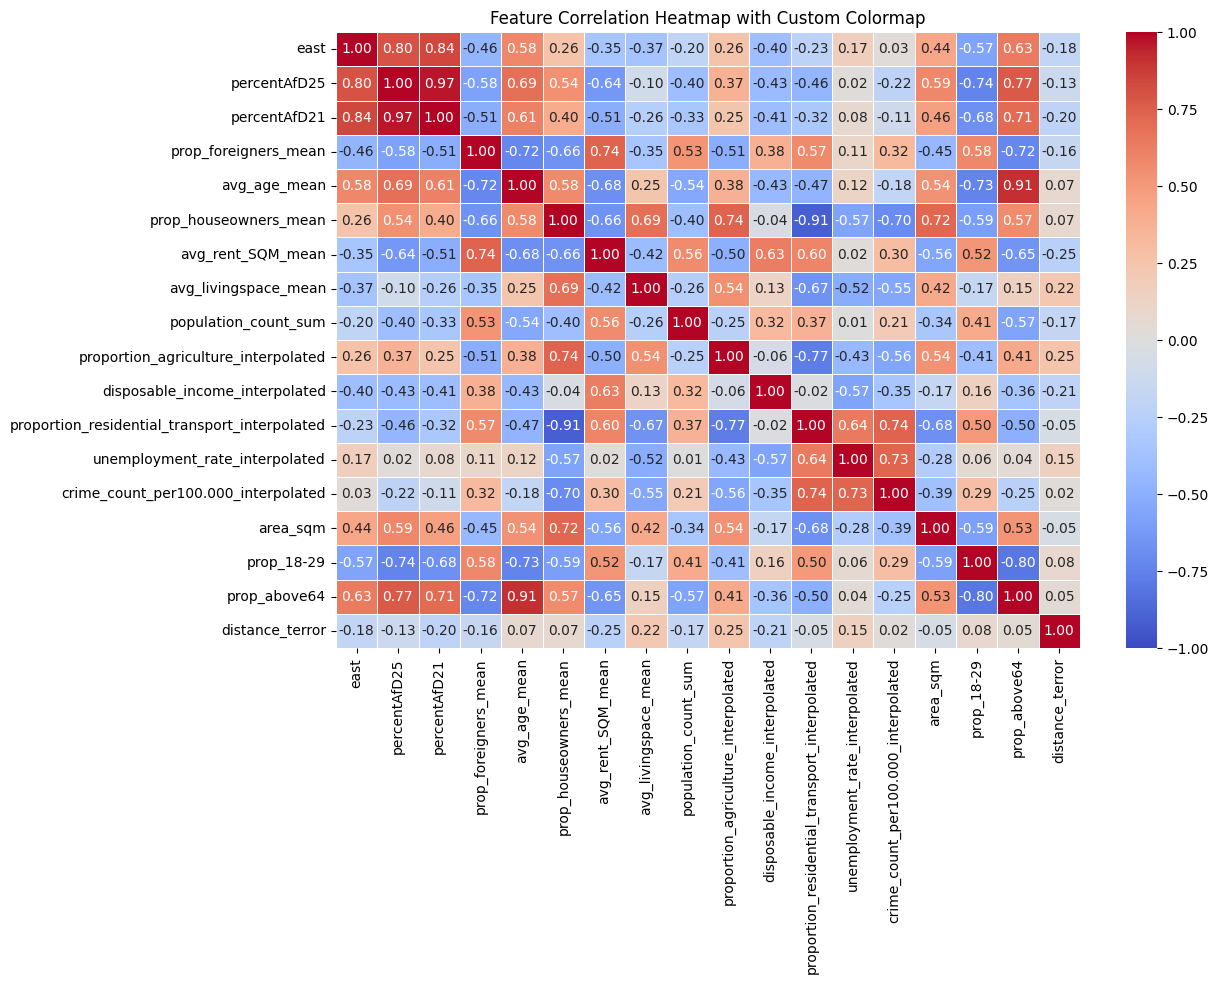

In [ ]:
# Compute correlation matrix for all numeric columns
corr_matrix = data.drop(columns=['geometry']).corr()
# correlation_matrix

# Set up the figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Feature Correlation Heatmap with Custom Colormap")

# Show the plot
plt.show()

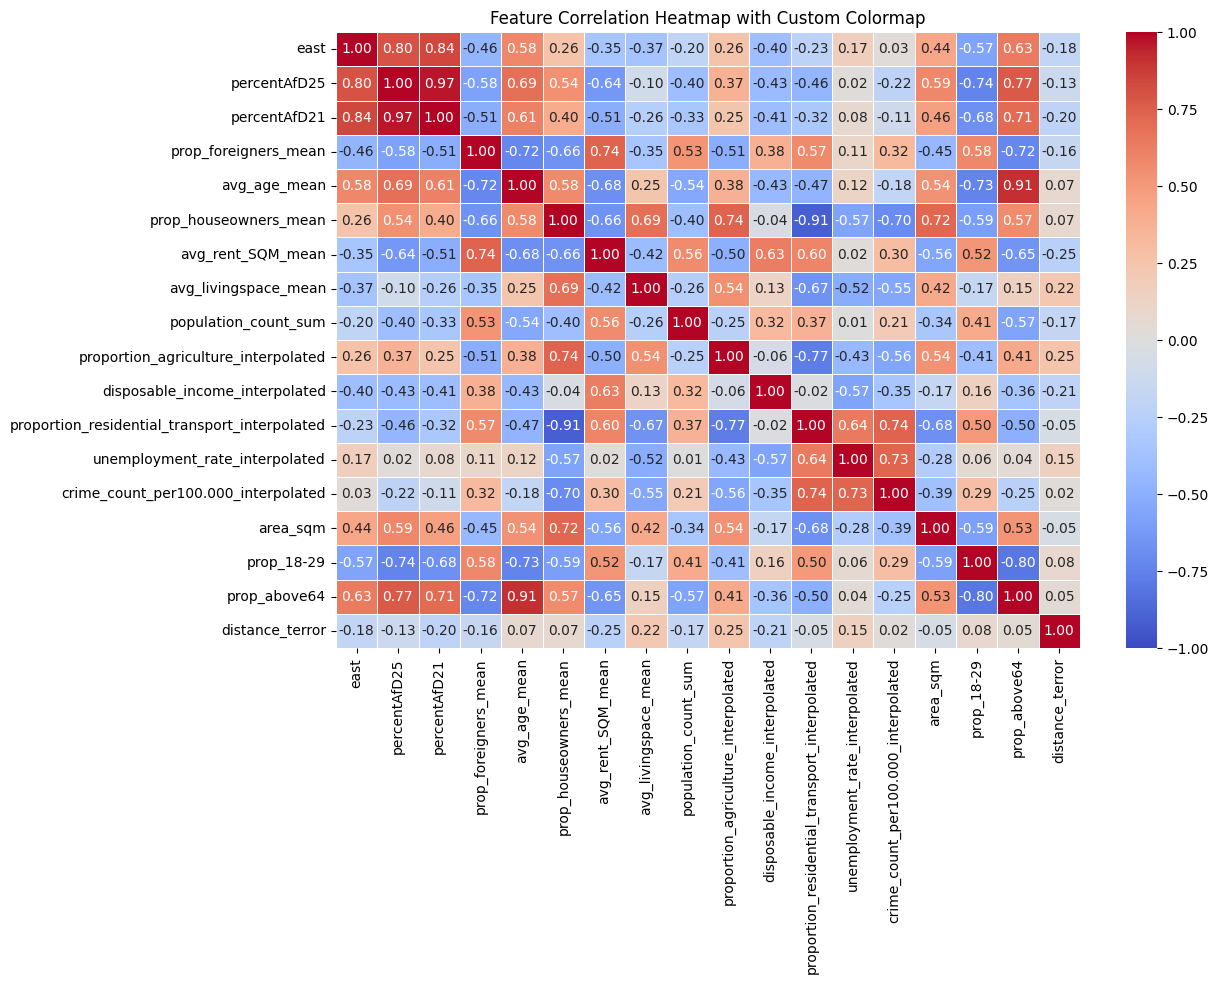

In [ ]:
# Compute correlation matrix for all numeric columns
corr_matrix_scaled = data_scaled.drop(columns=['geometry']).corr()
# correlation_matrix

# Set up the figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr_matrix_scaled, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Feature Correlation Heatmap with Custom Colormap")

# Show the plot
plt.show()

## To check if correlation values change after scaling:

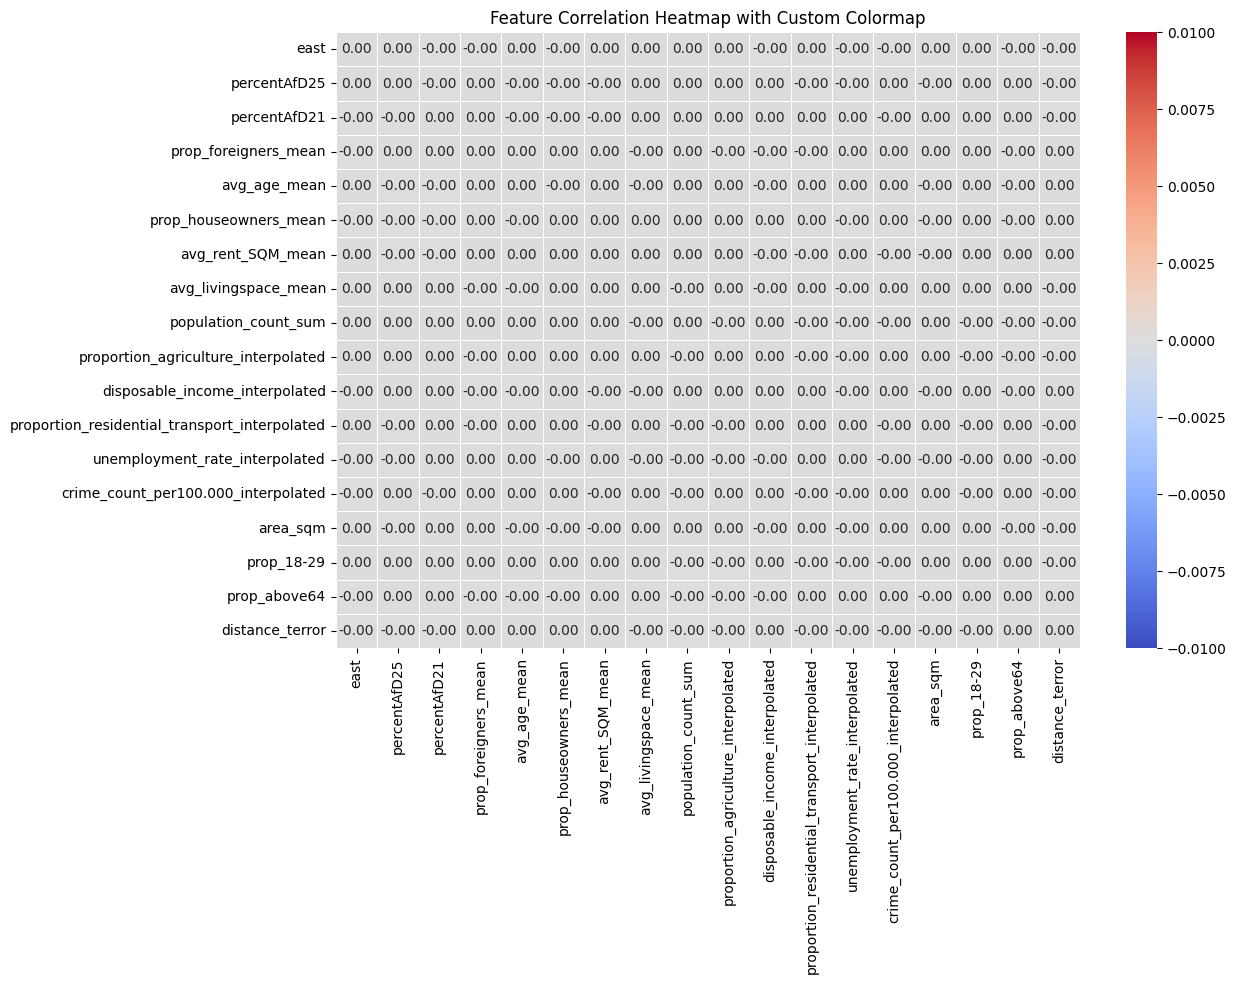

In [ ]:
new = corr_matrix - corr_matrix_scaled
new

# Set up the figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(new, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-0.01, vmax=0.01)

# Title
plt.title("Feature Correlation Heatmap with Custom Colormap")

# Show the plot
plt.show()

# Feature selection

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_vif = data_scaled.drop(columns=['percentAfD25', 'geometry'])
# Compute VIF for each independent variable
vif = pd.DataFrame()
vif["Feature"] = data_vif.columns
vif["VIF"] = [variance_inflation_factor(data_vif, i) for i in range(data_vif.shape[1])]

# Drop variables with high VIF (e.g., >10)
high_vif_features = vif[vif["VIF"] > 10]["Feature"].tolist()
data_filtered = data_vif.drop(columns=high_vif_features)

In [ ]:
vif

In [ ]:
high_vif_features

['prop_houseowners_mean', 'prop_above64']

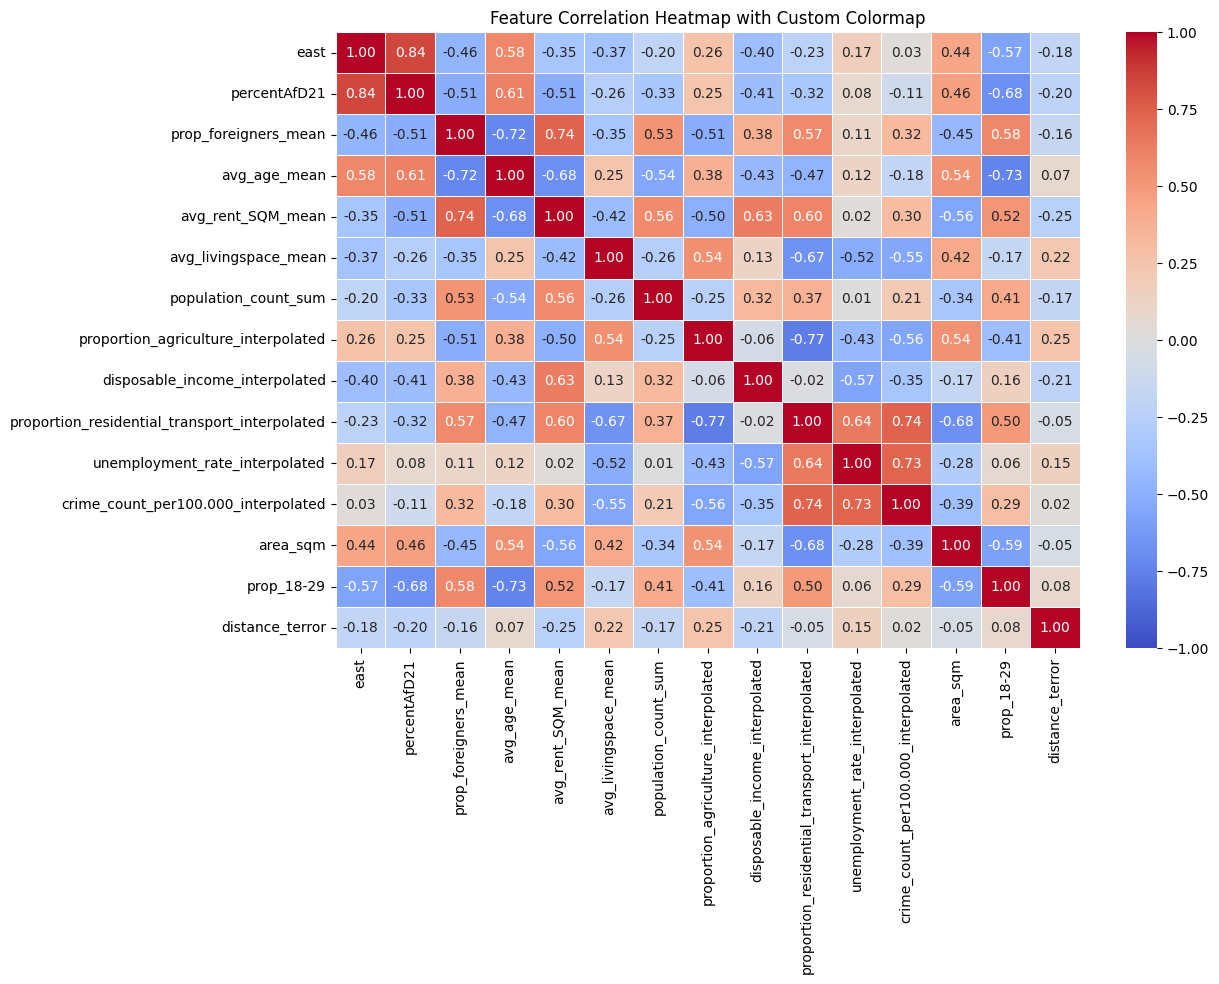

In [ ]:
# Compute correlation matrix for all numeric columns
corr_matrix = data_filtered.corr()
# correlation_matrix

# Define a custom colormap where -1 and 1 have the same color, and 0 is different
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkblue", "white", "darkblue"]  # Adjust colors if needed
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=256)

# Set up the figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Feature Correlation Heatmap with Custom Colormap")

# Show the plot
plt.show()

# Preparing data for model

In [ ]:
# Select independent variables (X), excluding the intercept
X = data_filtered.values  # Output: (n, p) array

# Select the dependent variable (y)
y = data[['percentAfD25']].values  # Output: (n, 1) array

# Extract centroid coordinates from Multipolygon geometries
coords = np.column_stack((data.geometry.centroid.x, data.geometry.centroid.y))

In [ ]:
# X

In [ ]:
# y

In [ ]:
# coords

## GWR Model

While a SRF accounts for spatial autocorrelation, its feature importance scores are reported globally in Python and do not show spatial variations of the relationships across space. To combat this, GWR is conducted, as it allows for relationships to vary over space and a clear visualisation of the coefficients per constituency (for further explanation, see Appendix D).
To optimize the model, a grid search was conducted to determine the best-performing hyperparameters (i.e., kernel function, bandwidth, and adaptivity of the kernel). Model selection was based on the Akaike Information Criterion (AICc) and spatial variation of coefficients, ensuring a balance between model complexity and goodness of fit. The optimal model resulted in a fixed Gaussian kernel with a bandwidth of 108,870.76 meters. For further discussion see Appendix D.


In [ ]:
# Define possible kernels
kernels = ['gaussian', 'bisquare', 'exponential']

# Define possible adaptiveness options
adaptive_options = [True, False]

results_dict = {}

for kernel in kernels:
    for adaptive in adaptive_options:
        try:
            # Automatically select the optimal bandwidth
            selector = Sel_BW(coords, y, X, kernel=kernel, fixed=not adaptive)
            optimal_bw = selector.search()  # Find best bandwidth

            # Fit GWR model with optimal bandwidth
            gwr_model = GWR(coords, y, X, optimal_bw, fixed=not adaptive, kernel=kernel)
            results = gwr_model.fit()

            # Store results
            key = f"{kernel}_{'adaptive' if adaptive else 'fixed'}"
            results_dict[key] = {
                "Bandwidth": optimal_bw,
                "AICc": results.aicc,
                "R2": results.R2,
                "Sigma": results.sigma2
            }

            print(f"Kernel: {kernel}, Adaptive: {adaptive}, Bandwidth: {optimal_bw}, AICc: {results.aicc:.2f}, R2: {results.R2:.4f}")

        except Exception as e:
            print(f"Error with kernel {kernel} and adaptiveness {adaptive}: {e}")

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame.from_dict(results_dict, orient="index")
print(results_df)

# Find best performing model based on AICc
optimal_setting = results_df['AICc'].idxmin()
optimal_bw = results_df.loc[optimal_setting, 'Bandwidth']
print('Optimal setting:', optimal_setting)
print('Optimal bandwidth:', optimal_bw)

Kernel: gaussian, Adaptive: True, Bandwidth: 73.0, AICc: 959.93, R2: 0.9848
Kernel: gaussian, Adaptive: False, Bandwidth: 106670.76, AICc: 899.71, R2: 0.9918
Error with kernel bisquare and adaptiveness True: Matrix is singular.
Error with kernel bisquare and adaptiveness False: Matrix is singular.
Kernel: exponential, Adaptive: True, Bandwidth: 73.0, AICc: 961.96, R2: 0.9858
Kernel: exponential, Adaptive: False, Bandwidth: 106364.51, AICc: 924.79, R2: 0.9912
                      Bandwidth        AICc        R2     Sigma
gaussian_adaptive         73.00  959.931095  0.984760  1.245303
gaussian_fixed        106670.76  899.707315  0.991797  0.792065
exponential_adaptive      73.00  961.962053  0.985771  1.200882
exponential_fixed     106364.51  924.794263  0.991220  0.852758
Optimal setting: gaussian_fixed
Optimal bandwidth: 106670.76


If fixed, then bw represents distance in meters. If adaptive, then bw represents amount of nearest neigbors!!!

In [ ]:
# Fit GWR model
model_1 = GWR(coords, y, X, bw=106670.76, fixed=True, kernel='gaussian')       # Choose correct settings!!!
results = model_1.fit()

# View results
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 299
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            509.637
Log-likelihood:                                                    -503.984
AIC:                                                               1039.969
AICc:                                                              1044.147
BIC:                                                              -1103.588
R2:                                                                   0.976
Adj. R2:                                                              0.975

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

# Results

In [ ]:
print('AICc:', results.aicc)

AICc: 899.707314760415


In [ ]:
# Get column names from X (excluding the intercept if added manually)
variable_names = ['Intercept'] + list(data_filtered.columns)

# Extract results from the model
coef_means = results.params.mean(axis=0)
coef_std = results.params.std(axis=0)
coef_min = results.params.min(axis=0)
coef_median = pd.DataFrame(results.params).median(axis=0)
coef_max = results.params.max(axis=0)

# Create a DataFrame
summary_df = pd.DataFrame({
    "Variable": variable_names,
    "Mean": coef_means,
    "STD": coef_std,
    "Min": coef_min,
    "Median": coef_median,
    "Max": coef_max
})

# Round values for better readability
summary_df = summary_df.round(2)
# Sort the DataFrame by Mean in descending order
summary_df = summary_df.sort_values(by="Mean", ascending=False).reset_index(drop=True)

# Display the DataFrame
summary_df

,Variable,Mean,STD,Min,Median,Max
0,Intercept,21.36,0.82,19.10,21.65,23.02
1,percentAfD21,8.44,1.58,5.59,9.08,11.38
2,area_sqm,0.36,0.41,-0.38,0.42,1.17
3,proportion_agriculture_interpolated,0.28,0.33,-0.22,0.16,1.57
4,unemployment_rate_interpolated,0.27,0.30,-0.36,0.24,1.48
5,disposable_income_interpolated,0.24,0.33,-0.31,0.09,1.54
6,distance_terror,0.23,0.51,-1.40,0.46,0.67
7,prop_foreigners_mean,0.13,0.23,-0.60,0.17,0.92
8,crime_count_per100.000_interpolated,0.10,0.22,-0.37,0.08,0.62
9,avg_age_mean,0.07,0.37,-0.90,0.03,1.00


In [ ]:
# Extract predicted values (fitted values)
predictions = results.mu

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(predictions, columns=["Predicted"])

# Add geometry column from data
predictions_df["geometry"] = data["geometry"]

# Convert to a GeoDataFrame
predictions_gdf = gpd.GeoDataFrame(predictions_df, geometry="geometry", crs=data.crs)

# Compute residuals
residuals = y.ravel() - results.mu
predictions_gdf["Residuals"] = residuals

# Extract local R^2 values
local_r2 = results.localR2
predictions_gdf["Local_R2"] = local_r2

In [ ]:
from libpysal.weights import KNN
from esda.moran import Moran

# Compute KNN spatial weights (matching your GWR adaptive bandwidth)
knn_weights = KNN.from_dataframe(predictions_gdf, k=73)
knn_weights.transform = "r"  # Row-standardize

# Compute Moran's I using KNN weights
moran_knn = Moran(residuals, knn_weights)

# Print results
print(f"KNN Moran's I: {moran_knn.I}")
print(f"KNN p-value: {moran_knn.p_norm}")

KNN Moran's I: -0.01555768286527033
KNN p-value: 0.11663751174409605


In [ ]:
predictions_gdf.head()

,Predicted,geometry,Residuals,Local_R2
0,15.194095,"MULTIPOLYGON (((545529.753 6076163.75, 547088....",0.061927,0.992216
1,16.139097,"MULTIPOLYGON (((482885.442 6035583.826, 482821...",-0.073695,0.990569
2,20.402258,"MULTIPOLYGON (((479877.791 5990290.587, 479947...",-0.042241,0.990560
3,16.945891,"MULTIPOLYGON (((562603.069 6055944.3, 562735.5...",-0.925710,0.992126
4,10.764647,"MULTIPOLYGON (((576026.352 6032272.051, 576122...",-0.011448,0.992806


<ipython-input-38-0a06e0614762>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = cm.get_cmap("YlOrRd")


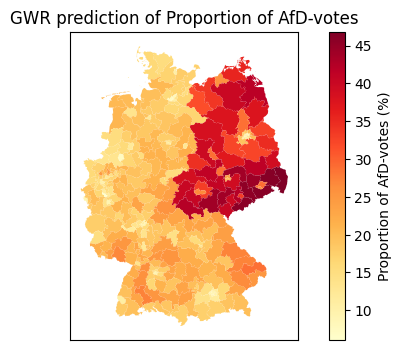

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

# Color map
afd_cmap = cm.get_cmap("YlOrRd")

# Plot the predicted values and store the colorbar in 'cbar'
cbar = predictions_gdf.plot(column="Predicted", cmap=afd_cmap, legend=True, ax=ax)

# Remove tick labels on both axes
ax.set_xticks([])
ax.set_yticks([])

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Set the title
ax.set_title("GWR prediction of Proportion of AfD-votes")

# Access the colorbar and add a label
cbar_ax = ax.get_figure().get_axes()[1]  # Second axis is the colorbar
cbar_ax.set_ylabel("Proportion of AfD-votes (%)")  # Add label

plt.show()

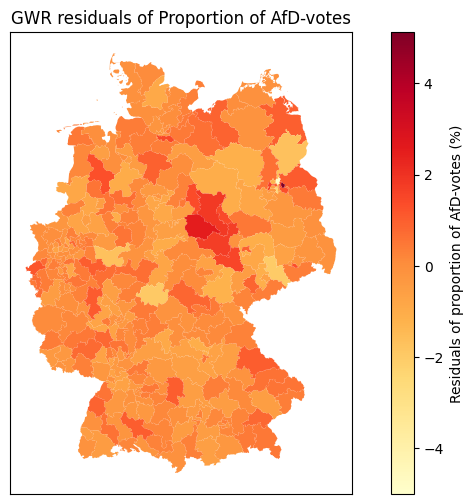

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the predicted values and store the colorbar in 'cbar'
cbar = predictions_gdf.plot(column="Residuals", cmap=afd_cmap, legend=True, ax=ax)

# Remove tick labels on both axes
ax.set_xticks([])
ax.set_yticks([])

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Set the title
ax.set_title("GWR residuals of Proportion of AfD-votes")

# Access the colorbar and add a label
cbar_ax = ax.get_figure().get_axes()[1]  # Second axis is the colorbar
cbar_ax.set_ylabel("Residuals of proportion of AfD-votes (%)")  # Add label

plt.show()

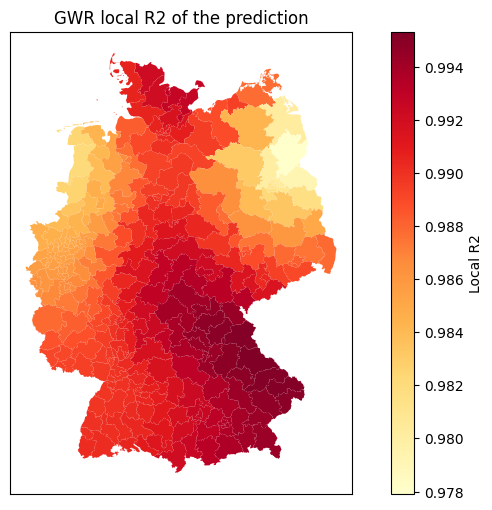

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the predicted values and store the colorbar in 'cbar'
cbar = predictions_gdf.plot(column="Local_R2", cmap=afd_cmap, legend=True, ax=ax)

# Remove tick labels on both axes
ax.set_xticks([])
ax.set_yticks([])

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Set the title
ax.set_title("GWR local R2 of the prediction")

# Access the colorbar and add a label
cbar_ax = ax.get_figure().get_axes()[1]  # Second axis is the colorbar
cbar_ax.set_ylabel("Local R2")  # Add label

plt.show()


In [ ]:
# Create a DataFrame with results and rename columns
coefficients_df = pd.DataFrame(results.params, columns=variable_names)
coefficients_df

,Intercept,east,percentAfD21,prop_foreigners_mean,avg_age_mean,avg_rent_SQM_mean,avg_livingspace_mean,population_count_sum,proportion_agriculture_interpolated,disposable_income_interpolated,proportion_residential_transport_interpolated,unemployment_rate_interpolated,crime_count_per100.000_interpolated,area_sqm,prop_18-29,distance_terror
0,22.443845,-1.450261,10.817434,0.034487,-0.316530,-1.042518,0.275150,-0.129422,-0.090842,0.145623,-0.656413,-0.359582,0.622157,-0.181756,-0.385902,0.598341
1,22.674828,-2.272161,11.379691,-0.012426,-0.388970,-0.734424,0.317967,-0.143386,-0.011026,0.007356,-0.562097,-0.289948,0.522998,-0.066309,-0.347086,0.602515
2,22.153232,-0.940473,10.366994,-0.003050,-0.402535,-1.076804,0.289443,-0.123155,-0.087337,0.283650,-0.504942,0.023706,0.268356,-0.020892,-0.365657,0.588458
3,22.145908,-0.599089,10.228107,0.029771,-0.344139,-1.263489,0.248554,-0.124157,-0.167673,0.347934,-0.642449,-0.147449,0.439864,-0.151092,-0.391302,0.605684
4,21.951866,-0.016001,9.785923,0.044212,-0.309384,-1.484573,0.192500,-0.113536,-0.217578,0.493350,-0.685354,-0.133332,0.454507,-0.161701,-0.401308,0.598018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,22.076003,-6.678434,9.725184,0.045016,-0.092241,-0.235347,0.222411,-0.154724,0.171846,0.070970,0.195131,0.328558,-0.078894,0.641358,-0.415025,0.523594
295,21.807025,-5.293879,9.245691,0.246177,0.037269,-1.114092,0.055757,0.070889,0.160734,0.043328,-0.131042,0.069593,0.086162,0.164532,-0.385888,0.554888
296,21.770713,-5.087730,9.189394,0.245007,0.017529,-1.195445,0.051947,0.113279,0.159206,0.040037,-0.247669,0.053876,0.144479,0.072518,-0.399270,0.557379
297,21.754093,-5.041345,9.195968,0.255962,0.037038,-1.145397,0.065729,0.111829,0.137941,0.032974,-0.223470,0.053049,0.117496,0.084353,-0.407052,0.572146


In [ ]:
# Significance criteria: |t| > 1.96 (95% confidence level)
significance = (results.tvalues < -1.96) | (results.tvalues > 1.96)

# Maak een DataFrame met significante waarden (True/False)
significance_df = pd.DataFrame(significance, columns=variable_names)
significance_df

,Intercept,east,percentAfD21,prop_foreigners_mean,avg_age_mean,avg_rent_SQM_mean,avg_livingspace_mean,population_count_sum,proportion_agriculture_interpolated,disposable_income_interpolated,proportion_residential_transport_interpolated,unemployment_rate_interpolated,crime_count_per100.000_interpolated,area_sqm,prop_18-29,distance_terror
0,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
2,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True
3,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True
4,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,True
295,True,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True
296,True,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True
297,True,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True


In [ ]:
# Create a new GeoDataFrame with just geometry
gdf_mapped = gdf[['geometry']].copy()  # Keep only geometry

# Add coefficient values
for col in coefficients_df.columns:
    gdf_mapped[col] = coefficients_df[col]  # Keep coefficients

# Add significance values with a suffix (_sig) to avoid overwriting coefficients
for col in significance_df.columns:
    gdf_mapped[col + "_sig"] = significance_df[col]  # Store significance separately

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

def plot_gwr_coefficient(variable_name):
    coef_col = variable_name  # Coefficients
    sig_col = variable_name + "_sig"  # Significance (True/False)

    if coef_col not in gdf_mapped.columns or sig_col not in gdf_mapped.columns:
        print(f"Variable '{variable_name}' not found in dataset.")
        return

    fig, ax = plt.subplots(figsize=(10, 8))

    # Get coefficient range
    vmin, vmax = gdf_mapped[coef_col].min(), gdf_mapped[coef_col].max()
    abs_max = max(abs(vmin), abs(vmax))
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    # Custom colormap: teal -> beige -> brown-gold
    afd_cmap = LinearSegmentedColormap.from_list(
        "afd_custom",
        ['#fae79d', '#eeede0', '#714f43'],
        N=256
    )

    # Plot all polygons with coefficient values
    gdf_mapped.plot(
        column=coef_col,
        cmap=afd_cmap,
        norm=norm,
        edgecolor="gray",
        linewidth=0.2,
        legend=True,
        ax=ax
    )

    # Optional: highlight significant areas
    # significant_areas = gdf_mapped[gdf_mapped[sig_col]]
    # significant_areas.plot(facecolor="none", edgecolor="black", linewidth=1.5, ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Effect of '{variable_name}' on proportion of AfD-votes")

    # Label colorbar if present
    try:
        cbar_ax = ax.get_figure().get_axes()[1]
        cbar_ax.set_ylabel(f"Coefficients of '{variable_name}'")
    except IndexError:
        pass

    plt.show()

In [ ]:
data_filtered.columns

Index(['east', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
       'proportion_agriculture_interpolated', 'disposable_income_interpolated',
       'proportion_residential_transport_interpolated',
       'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
       'area_sqm', 'prop_18-29', 'distance_terror'],
      dtype='object')

TO DO: CHANGE THE TITLE

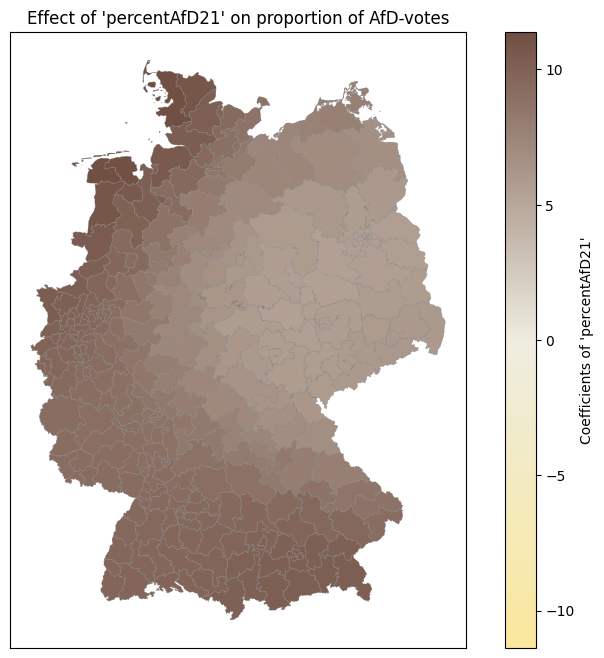

In [ ]:
plot_gwr_coefficient("percentAfD21")

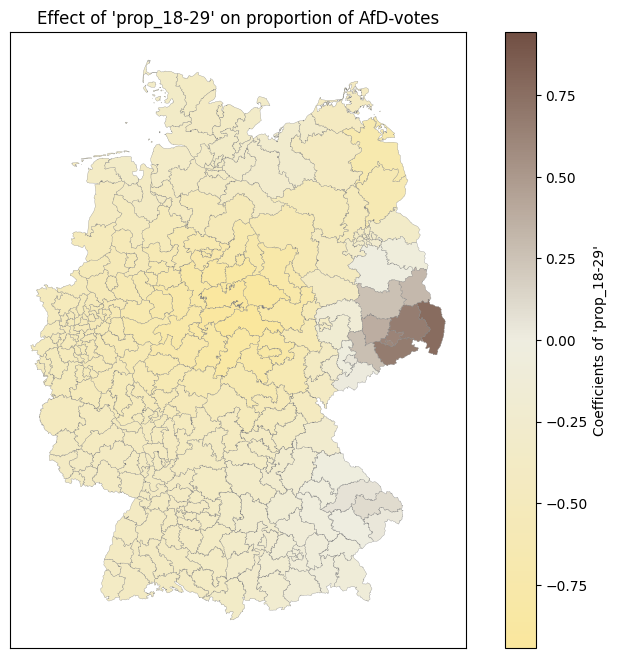

In [ ]:
plot_gwr_coefficient("prop_18-29")

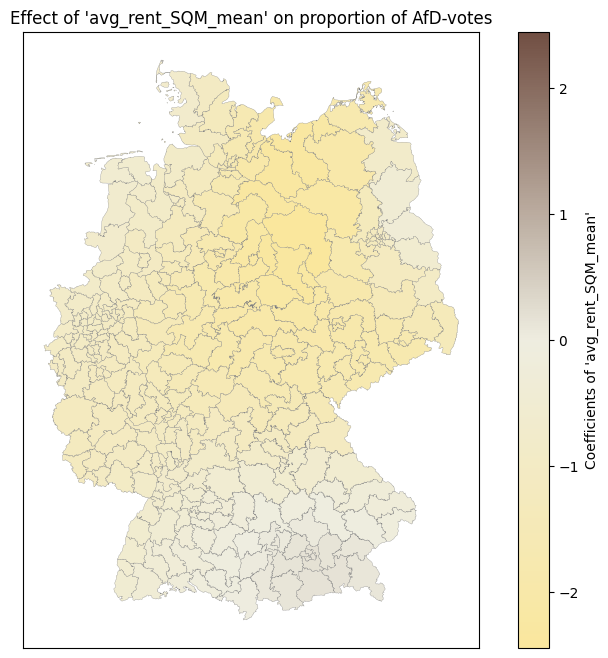

In [ ]:
plot_gwr_coefficient("avg_rent_SQM_mean")

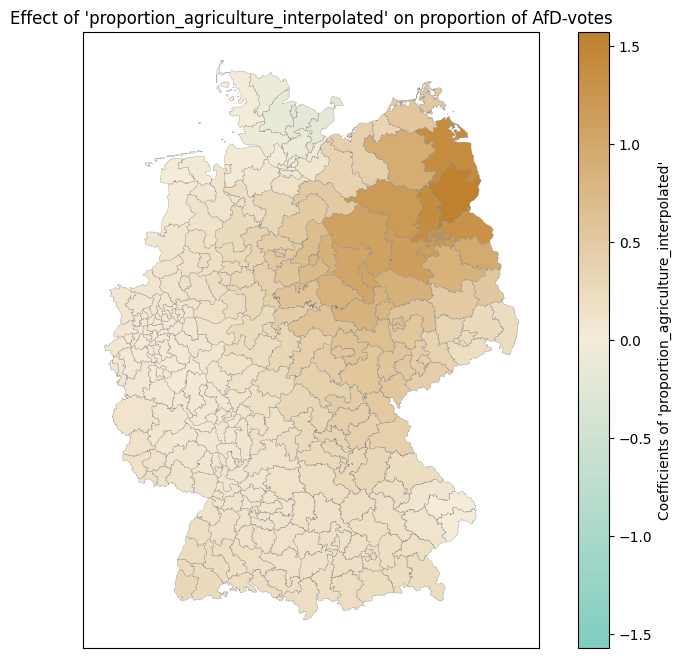

In [ ]:
plot_gwr_coefficient("proportion_agriculture_interpolated")

In [ ]:
# def plot_gwr_coefficients_grid(variable_names):
#     num_vars = len(variable_names)
#     num_cols = 2  # Two maps per row
#     num_rows = (num_vars + 1) // num_cols  # Calculate the required number of rows

#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 8 * num_rows))
#     axes = axes.flatten()  # Flatten axes array for easy iteration

#     for i, variable_name in enumerate(variable_names):
#         coef_col = variable_name  # Coefficients
#         sig_col = variable_name + "_sig"  # Significance (True/False)

#         if coef_col not in gdf_mapped.columns or sig_col not in gdf_mapped.columns:
#             print(f"Variable '{variable_name}' not found in dataset.")
#             continue

#         ax = axes[i]

#         # Normalize colormap to center around 0 (white)
#         vmin, vmax = gdf_mapped[coef_col].min(), gdf_mapped[coef_col].max()
#         norm = mcolors.TwoSlopeNorm(vmin=-max(abs(vmin), abs(vmax)), vcenter=0, vmax=max(abs(vmin), abs(vmax)))

#         # Plot all polygons with coefficient values
#         gdf_mapped.plot(column=coef_col, cmap="coolwarm", norm=norm, edgecolor="gray", linewidth=0.2, legend=True, ax=ax)

#         # Remove tick labels and axis labels
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel("")
#         ax.set_ylabel("")

#         # Title for each subplot
#         ax.set_title(f"{variable_name}")

#     # Remove any unused axes (if the number of variables is odd)
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

In [ ]:
# print(data_filtered.columns)

In [ ]:
# plot_gwr_coefficients_grid(['east', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
#        'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
#        'proportion_agriculture_interpolated', 'disposable_income_interpolated',
#        'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
#        'area_sqm', 'population_density_km2', 'attack', 'distance_terror'])

## For comparison

In [ ]:
def plot_gwr_comparison(variable_name):
    coef_col = variable_name
    sig_col = variable_name + "_sig"
    actual_col = variable_name

    if coef_col not in gdf_mapped.columns or sig_col not in gdf_mapped.columns or actual_col not in data.columns:
        print(f"Variable '{variable_name}' not found in one of the datasets.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Left Plot: Actual Values
    data.plot(column=actual_col, cmap="YlOrRd", edgecolor="gray", linewidth=0.5, legend=True, ax=axes[0])
    axes[0].set_title(f"Actual Values for '{variable_name}'")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")

    # Right Plot: GWR Coefficients
    vmin, vmax = gdf_mapped[coef_col].min(), gdf_mapped[coef_col].max()
    abs_max = max(abs(vmin), abs(vmax))
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    # Custom colormap: light yellow -> light gray -> red
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_div_cmap",
        ["#80cdc1", "#f4ecd9", "#bf812d"],
        N=256
    )

    gdf_mapped.plot(column=coef_col, cmap=custom_cmap, norm=norm, edgecolor="gray", linewidth=0.2, legend=True, ax=axes[1])
    axes[1].set_title(f"GWR Coefficients for '{variable_name}'")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    # Optional: Label the colorbar
    try:
        cbar = axes[1].get_figure().get_axes()[2]
        cbar.set_ylabel(f"Coefficient of '{variable_name}'")
    except IndexError:
        pass

    plt.tight_layout()
    plt.show()

In [ ]:
data_filtered.columns

Index(['east', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
       'proportion_agriculture_interpolated', 'disposable_income_interpolated',
       'proportion_residential_transport_interpolated',
       'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
       'area_sqm', 'prop_18-29', 'distance_terror'],
      dtype='object')

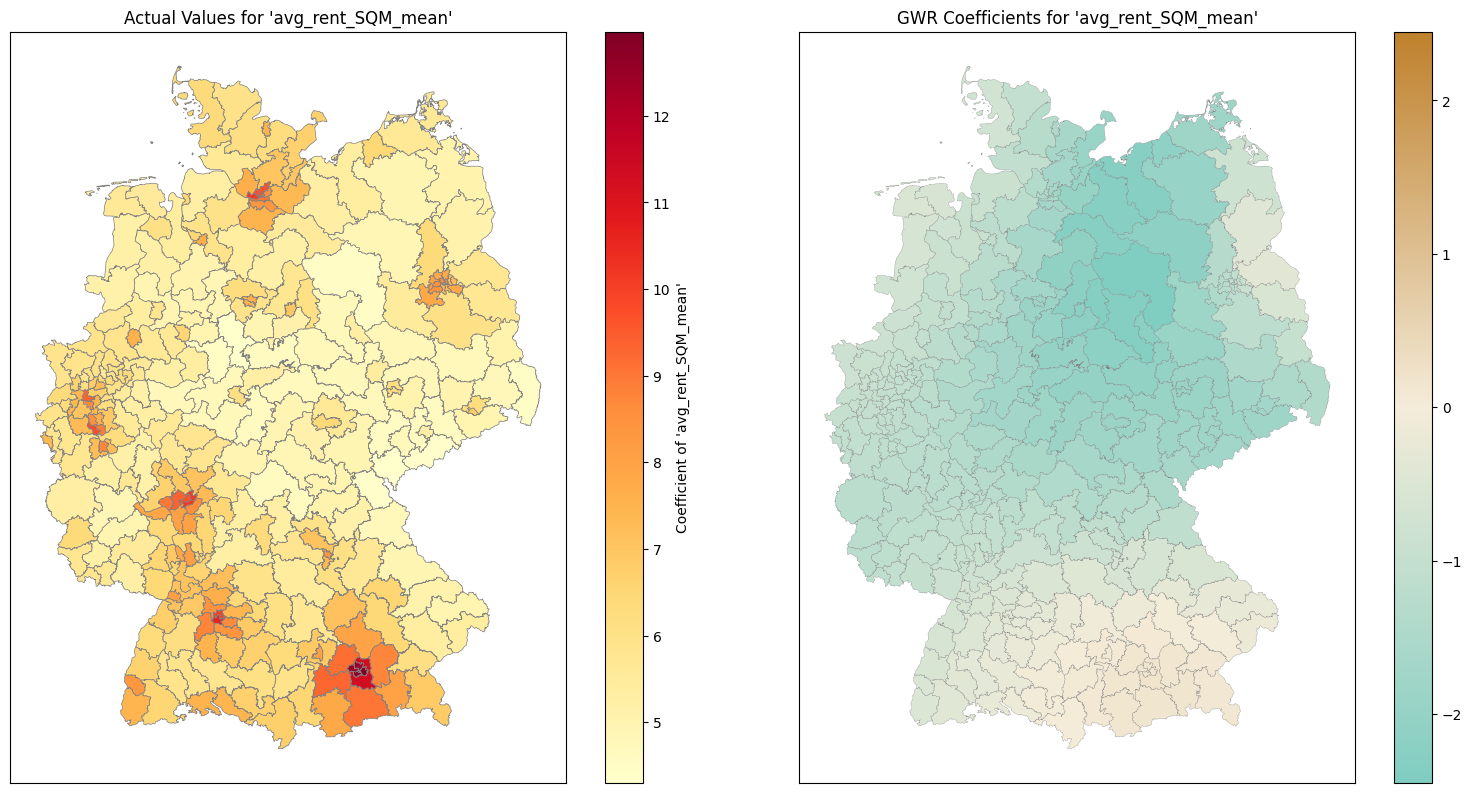

In [ ]:
plot_gwr_comparison("avg_rent_SQM_mean") # Replace with variable name you like